# The Firm Environment
The environment has the following attributes:
1. `num_firms`: number of firms
2. `num_periods`: number of periods
3. `endowments`: each firm start with an endowment that is randomly generated from a uniform distribution 
4. `Avarage productivity`

The `step` function is a method within the `FirmEnvironment` class. It simulates a time step or period in an environment where multiple firms make production decisions and receive rewards based on their actions and the state of the environment. Here's a breakdown of how the function works:

1. `self` refers to the instance of the `FirmEnvironment` class that the method is called on.
2. `actions` is a list or array of actions taken by each firm in the current period. An action of 0 indicates that a firm chooses not to produce, and an action of 1 indicates that a firm chooses to produce.

The function proceeds as follows for each firm:

1. `rewards = np.zeros(self.num_firms)` initializes an array to store the rewards earned by each firm. It has the same length as the number of firms in the environment, and all rewards are initially set to 0.

2. `productivity = np.random.normal(0.5, 0.1)` generates a random value from a normal distribution with a mean of 0.5 and a standard deviation of 0.1. This value represents the productivity level of the firm for the current period.

3. `if actions[i] == 0:` checks if the action for the current firm is 0, meaning the firm chooses not to produce. If this condition is met, the firm receives a reward of 0.5.

4. If the action is not 0 (i.e., the firm chooses to produce), the function proceeds to the following conditions:
   - `if productivity > self.avg_productivity:` checks if the firm's productivity is above the average productivity of the firms in the environment. If so, the firm receives a reward of 1.0.
   - If the firm's productivity is not above the average, it receives a reward of -0.2.

5. `self.endowments[i] += rewards[i]` updates the endowment (resource level) of the current firm by adding the calculated reward to it.

After iterating through all firms and calculating their rewards and updated endowments, the function returns two values:
1. `rewards`: An array containing the rewards earned by each firm in the current period.
2. `self.endowments.copy()`: A copy of the updated endowments array representing the resource levels of each firm after the period.

This `step` function is used to advance the simulation of the firm environment over time, considering firms' production decisions, their productivity, and the resulting rewards and resource changes.

In [2]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

2023-09-08 14:15:04.760753: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [323]:
def norm(series):
        min_value = np.min(series)
        max_value = np.max(series)
        return ((series - min_value) / (max_value - min_value))

class FirmEnvironment:
    def __init__(self, num_firms, num_periods, subsidy):
        self.num_firms          = num_firms
        self.num_periods        = num_periods
        self.endowments         = np.ones(self.num_firms) #np.random.normal(1, 0.02, num_firms)
        self.productivity       = np.ones(self.num_firms) #np.random.normal(1, 0.02, num_firms)
        self.production         = np.ones(self.num_firms)
        self.avg_productivity   = np.mean(self.productivity * self.production) / (np.count_nonzero(self.production))
        self.recession          = 0
        self.failed             = np.zeros(self.num_firms)
        self.subsidy            = subsidy

    def step(self, actions):
        rewards             = np.zeros(self.num_firms)
        
                
        if self.recession <0 and  not self.subsidy:
            percentile_value = 5
        elif self.recession <0 and self.subsidy:
            percentile_value = 1
        else:
            percentile_value = 0 
        filtered_endowments = self.endowments[self.endowments != 0]

        if len(filtered_endowments) > 0:
            threshold = np.percentile(filtered_endowments, percentile_value)
        else:
            threshold = 0  # Set a default threshold or handle this case as needed

        for i in range(self.num_firms):
            productivity    = self.productivity[i]
            change_end      = 0
            action          = actions[i]

            if self.endowments[i] > 0 and self.endowments[i] < np.percentile(filtered_endowments, 10) and self.subsidy and self.recession < 0:
                self.endowments[i] += 0.20 * self.endowments[i]
            elif self.endowments[i] > 0 and self.endowments[i] >= np.percentile(filtered_endowments, 10) and self.subsidy and self.recession < 0:
                    self.endowments[i] -= 0.05 * self.endowments[i]

            if  (self.failed[i]==0) and ((self.endowments[i]>= threshold)):

                
                #is not out of the markets
                if (action == 0) :  # Do not invest

                        #risk free
                        
                        change_end              +=  np.random.normal(0.01 + self.recession * 0.1, 0.05, 1) * self.endowments[i] #risk free
                        self.production[i]       = 0 
                        self.productivity[i]    += np.random.normal(0.01, 0.1,1) * productivity
                
                
                else:  # Invest
                    change_end              -= np.random.normal(0.02 - self.recession * 0.1, 0.05,1) * self.endowments[i]
                    self.productivity[i]    += np.random.normal(0.08, 0.1,1) * productivity #incresing in  productivity
                    self.production[i]       = 1 # produce

                if  productivity  > np.percentile(self.productivity[self.productivity>0], 50): #allocating revenues

                    change_end  += np.random.normal(0.08 + self.recession * 0.1 , 0.05, 1) * self.endowments[i]
                    rewards[i]  = + 0.5
                     
                    #print("Production premium")

                else:

                    rewards[i]      =    - 0.5
                    change_end      -=    np.random.normal(0.08 + self.recession * 0.1, 0.05, 1) * self.endowments[i]
                    #print("Production loss")
                self.endowments[i] += change_end #updating endowments 
            else:
                if self.failed[i] ==0:
                    if np.random.choice([True, False], 1, 0.1 if self.subsidy and self.recession<0 else 0.8):
                        #firm failed
                        self.production[i]  = 0  
                        rewards[i]          = -1
                        self.failed[i]      = 1 
                        self.endowments[i]  = 0
                    else:
                        self.endowments[i] -=    np.random.normal(0.03 + self.recession * 0.1, 0.05, 1) * self.endowments[i]
                        rewards[i]          = - 0.7
                else:
                    self.productivity[i]    = 0
                    self.production[i]      = 0
                    rewards[i]              = -1
                    self.endowments[i]      = 0


            
                 
        
            
            #normalize
            #self.endowments     = norm(self.endowments) # between 0 and 1
            #self.productivity   = norm(self.productivity)
            
            
            self.failed = self.failed.astype(bool)
            #updating avarage productivity
            if np.count_nonzero(self.production) > 0:
                self.avg_productivity = np.mean(self.productivity[~self.failed])
            else:
                self.avg_productivity = 0.0  # Set to a default value when there are no firms in production 

        # Update average productivity
        return rewards, self.endowments.copy(), self.productivity.copy(), self.failed.copy(), self.avg_productivity



# The Ai Model
Of course, I'll provide a more detailed explanation of each component of the `AIModel` class to help you understand its structure and purpose.


1. **Class Inheritance (`super()`):**
   - The class `AIModel` is created by inheriting from `tf.keras.Model`. This means that `AIModel` is a subclass of `tf.keras.Model` and can make use of its functionality.
   - The `super(AIModel, self).__init__()` line in the constructor (`__init__`) initializes the parent class `tf.keras.Model`. This is necessary to properly set up the class hierarchy and enable the use of Keras model functionalities.

2. **Initializer (`__init__`):**
   - The `__init__` method is a special method that gets called when an instance of the class is created. It initializes the attributes and properties of the instance.
   - Within the `__init__` method of `AIModel`, the parent class is initialized using `super(AIModel, self).__init__()`.
   - Two dense layers are defined:
     - `self.dense1` is a fully connected (dense) layer with 16 units and ReLU activation. It applies a linear transformation to its input and then applies the ReLU activation function element-wise.
     - `self.dense2` is another dense layer with 2 units and softmax activation. Softmax activation converts raw scores into probabilities, making it suitable for multi-class classification tasks.

3. **Model Forward Pass (`call` method):**
   - The `call` method defines the forward pass of the neural network. It specifies how the input data flows through the layers to produce an output.
   - When you call an instance of `AIModel` (e.g., `output = model(input)`), this method is executed.
   - Inside the `call` method:
     - `inputs` is the input data (endowments in your case) that you pass to the model.
     - `x = self.dense1(inputs)` applies the first dense layer to the input. The output `x` is the result after passing through the first layer.
     - `return self.dense2(x)` applies the second dense layer to the output of the first dense layer. The final result is returned as the output of the model.

In summary, the `AIModel` class defines a neural network model that consists of two fully connected layers with specific activation functions. The `call` method describes how the input is transformed through the layers to produce the model's output. This model architecture is designed to capture the decision-making process of a firm in your simulation, where the input (endowments) is transformed through the layers to make decisions based on the defined activations.

In [267]:
class AIModel(tf.keras.Model):
    def __init__(self, rnn_units=64):
        super(AIModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(16, activation="relu")
        self.rnn = tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, activation="relu")
        #self.dense2 = tf.keras.layers.Dense(2, activation="softmax")  # Final layer with 2 units and softmax activation
        self.dense2 = tf.keras.layers.Dense(1, activation="sigmoid")
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.rnn(x)  # TD layer
        return self.dense2(x)


# Reinforcment learning setup
 I explain each part of the "Reinforcement Learning Setup" section step by step:



1. **Environment Initialization (`env`):**
   - Here, you create an instance of the `FirmEnvironment` class, which simulates the economic environment in which the firms operate.
   - `num_firms=5` specifies the number of firms in the simulation.
   - `num_periods=100` sets the number of time periods for which the simulation will run.



2. **Model Initialization (`model`):**
   - This line creates an instance of the `AIModel` class, which represents the neural network model that acts as the AI agent for each firm.
   - This model will be used to make decisions based on the input state (firm's endowments).



3. **Optimizer Initialization (`optimizer`):**
   - Here, you create an instance of the Adam optimizer from TensorFlow's `tf.keras.optimizers` module.
   - Adam is an optimization algorithm commonly used for training neural networks.
   - The learning rate is set to `0.001`, which determines the step size taken during optimization.



4. **Action Selection (`get_action` function):**
   - This function takes the current state (firm's endowments) as input and returns an action for the firm to take (produce or not produce).
   - `epsilon` represents the exploration factor. With a probability of `epsilon`, a random action is chosen to encourage exploration.
   - If a random number is less than `epsilon`, a random action (0 or 1) is selected.
   - Otherwise, the model's neural network is used to predict the action based on the current state. The `np.argmax` function returns the index of the maximum value in the model's output, which corresponds to the chosen action.


5. **Model Update (`update_model` function):**
   - This function updates the AI model based on the experiences gained from interacting with the environment.
   - Inside the `with tf.GradientTape() as tape:` block, you define the computation for calculating the loss and gradients.
   - `logits` are the model's raw output predictions for the given states.
   - `actions_one_hot` creates one-hot encoded vectors for the chosen actions.
   - The categorical cross-entropy loss is calculated between the predicted logits and the one-hot encoded actions.
   - The loss is then scaled by the rewards received from the environment.
   - Gradients of the loss with respect to the model's trainable variables are calculated using automatic differentiation (`tape.gradient`).
   - The optimizer is used to apply the gradients to update the model's parameters.

In summary, the "Reinforcement Learning Setup" section initializes the environment, the AI model, and the optimizer. It also defines functions for selecting actions and updating the model based on the interactions with the environment. This section sets up the foundational components for running the reinforcement learning loop, where the AI firm interacts with the environment and learns to make better decisions over time.

In [321]:
import random
import tensorflow as tf

def get_action(history, epsilon=0.3, model=AIModel()):
    if random.random() < epsilon:
        
        history_length = len(history)
        out = [[random.choice([0, 1]) for _ in range(history_length)]]
        return out

    # Convert history data and add batch dimension
    history_tensor = tf.convert_to_tensor(history, dtype=tf.float32)[tf.newaxis, :, :]

    logits = model(history_tensor)
    
    chosen_action = tf.cast(logits >= 0.5, tf.int32).numpy()[0]
    
    return chosen_action.tolist()

def update_model(input_history, action, rewards, model):
    with tf.device("/GPU:0"):
        # Convert input history data and add batch dimension
        history_tensor = tf.convert_to_tensor(input_history, dtype=tf.float32)[tf.newaxis, :, :]

        # Convert action to binary format (0 or 1)
        action_binary = tf.cast(action, dtype=tf.float32)


        with tf.GradientTape() as tape:
            logits = model(history_tensor)
            logits = logits[0]
            # Ensure logits shape is (batch_size, sequence_length, 1) for binary classification
            if logits.shape[-1] != 1:
                raise ValueError("Logits shape should have a single output for binary classification.")

            # Calculate the binary cross-entropy loss
            loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

            loss = loss_fn(action_binary, logits)

            # Multiply the loss by rewards and compute the mean
            loss = tf.reduce_mean(loss * rewards)

        # Compute gradients and apply them using the model's optimizer
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))



# Training the AI Firm
Certainly, let's break down the code block that runs the reinforcement learning loop:

```python
num_episodes = 1000

for episode in range(num_episodes):
    state = env.endowments.copy()
    total_reward = 0

    for period in range(env.num_periods):
        action = get_action(state)
        rewards, next_state = env.step([action] * env.num_firms)
        total_reward += np.sum(rewards)

        # Reshape state and next_state to have a minimum of 2 dimensions
        state = np.expand_dims(state, axis=0)
        next_state = np.expand_dims(next_state, axis=0)

        update_model(state, action, rewards)
        state = next_state

    print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward:.2f}")
```

1. **Episode Loop (`for episode in range(num_episodes):`):**
   - The outer loop runs for the specified number of episodes (`num_episodes`), which represents the total number of times the AI firm interacts with the environment to learn and improve its decision-making.

2. **Initial State (`state = env.endowments.copy()`):**
   - At the beginning of each episode, the `state` is initialized with a copy of the initial endowments of the firms in the environment. This is the starting point for the AI firm's decision-making process.

3. **Total Reward Accumulation (`total_reward = 0`):**
   - The `total_reward` variable is initialized to 0 for the current episode. This variable accumulates the rewards obtained by the AI firm during its interactions with the environment in this episode.

4. **Time Period Loop (`for period in range(env.num_periods):`):**
   - Within each episode, a loop runs for the specified number of time periods (`env.num_periods`). This loop represents the sequential decisions the AI firm makes within the given episode.

5. **Choosing an Action (`action = get_action(state)`):**
   - The AI firm uses the `get_action` function to choose an action based on the current state (`state`), which represents the firm's endowments.

6. **Interacting with the Environment (`rewards, next_state = env.step([action] * env.num_firms)`):**
   - The chosen action is used to interact with the environment for all firms simultaneously. The `env.step` function returns the rewards obtained and the next state (`next_state`) after taking the chosen action.

7. **Reward Accumulation (`total_reward += np.sum(rewards)`):**
   - The rewards obtained from the environment are summed up and added to the `total_reward` variable for the current episode. This reflects the total reward obtained by the AI firm up to the current time period.

8. **Reshaping State and Next State (`state = np.expand_dims(state, axis=0)` and `next_state = np.expand_dims(next_state, axis=0)`):**
   - Before updating the AI model, the `state` and `next_state` are reshaped to have a minimum of 2 dimensions. This is necessary to match the expected input shape of the model.

9. **Updating the AI Model (`update_model(state, action, rewards)`):**
   - The `update_model` function is called to update the AI model's parameters based on the experiences gained during this time period.

10. **Updating Current State (`state = next_state`):**
    - The `state` is updated to the `next_state`, which represents the firm's endowments after taking the chosen action. This updated state becomes the starting point for the next time period.

11. **Printing Episode Information (`print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward:.2f}")`):**
    - After completing all time periods in an episode, information about the current episode is printed, including the episode number and the total reward obtained by the AI firm in that episode.

In summary, this code block runs a reinforcement learning loop where the AI firm interacts with the environment for a specified number of episodes and learns to make better decisions over time. The AI firm's actions are based on its current state (firm's endowments), and it accumulates rewards by making decisions in each time period. The AI model is updated using the collected experiences to improve its decision-making capabilities.

In [332]:
# Training the AI Firm
num_episodes = 300
def traning(num_episodes):
    for episode in range(num_episodes):
        # Reinforcement Learning Setup
        env = FirmEnvironment(num_firms=20, num_periods=20, subsidy=False)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

        # Define a list of neural network models
        firm_models = [AIModel() for _ in range(env.num_firms)]

        #define history array
        history = np.zeros((env.num_firms, env.num_periods, 5))

        for period in range(env.num_periods):  # Loop over periods first
            out_of_market_counts = 0
            actions = []
            current_state = np.array([env.endowments.copy(), env.productivity.copy()])

            for firm_index in range(env.num_firms):
                action = get_action(history[firm_index, 0 if period < 4 else period - 4 : 4 if period < 4 else period, :], 0.1, firm_models[firm_index])
                action = [item for sublist in action for item in sublist]
                actions.append(action)
            # Slice the actions list to select only the actions for the current period
            if period<4:
                actions_for_period = [action[period] for action in actions]
            else:
                actions_for_period = [action[3] for action in actions]
            rewards, next_end, next_prod, failed, avg_productivity  = env.step(actions_for_period)
                
                
                
            

            for firm_index in range(env.num_firms):
                update_model(
                    history[firm_index, 0 if period<4 else period-4:4 if period<4 else period, :],
                    actions[firm_index],
                    rewards[firm_index],
                    firm_models[firm_index]
                )
                history[firm_index, period, 0] = rewards[firm_index]
                history[firm_index, period, 1] = current_state[0, firm_index]
                history[firm_index, period, 2] = current_state[1, firm_index]
                history[firm_index, period, 3] = int(actions_for_period[firm_index])
                history[firm_index, period, 4] = env.avg_productivity
                
                current_state[0, firm_index] = next_end[firm_index]
                current_state[1, firm_index] = next_prod[firm_index]
            
            # Update the neural network models
        
                
            
            # computing the total reward
            total_reward = np.sum(rewards)

            # compute the avarage reward

            avg_reward = np.mean(rewards)

            # Calculate share of firms staying out of the market
            
            share_out_of_market = np.count_nonzero(actions_for_period)/ env.num_firms

            print(
                f"Episode: {episode} Period: {period} Total Reward: {total_reward:.2f} \t Avg. reward: {avg_reward:.2f} \t Share of firms that invest inRD: {share_out_of_market:.2f} "
            )
    for firm_index in range(env.num_firms):
        firm_models[firm_index].save(f'models/firm_model_{firm_index}')

    return firm_models
firm_models = traning(num_episodes=num_episodes)



Episode: 0 Period: 0 Total Reward: -10.00 	 Avg. reward: -0.50 	 Share of firms that invest inRD: 0.95 
Episode: 0 Period: 1 Total Reward: -1.00 	 Avg. reward: -0.05 	 Share of firms that invest inRD: 0.50 
Episode: 0 Period: 2 Total Reward: -2.00 	 Avg. reward: -0.10 	 Share of firms that invest inRD: 0.60 
Episode: 0 Period: 3 Total Reward: -1.00 	 Avg. reward: -0.05 	 Share of firms that invest inRD: 0.40 
Episode: 0 Period: 4 Total Reward: -1.00 	 Avg. reward: -0.05 	 Share of firms that invest inRD: 0.60 
Episode: 0 Period: 5 Total Reward: -3.00 	 Avg. reward: -0.15 	 Share of firms that invest inRD: 0.45 
Episode: 0 Period: 6 Total Reward: 0.00 	 Avg. reward: 0.00 	 Share of firms that invest inRD: 0.65 
Episode: 0 Period: 7 Total Reward: -2.00 	 Avg. reward: -0.10 	 Share of firms that invest inRD: 0.40 
Episode: 0 Period: 8 Total Reward: 0.00 	 Avg. reward: 0.00 	 Share of firms that invest inRD: 0.55 
Episode: 0 Period: 9 Total Reward: 0.00 	 Avg. reward: 0.00 	 Share of firms

## Saving the neural network


In [325]:
# Compile the loaded model with the same configuration as during training
optimizer   = Adam(learning_rate = 0.01)  # Use the same optimizer configuration as during training
env         = FirmEnvironment(20, 20,False) 

# Load individual firm models using SavedModel format
loaded_firm_models = []

for firm_index in range(env.num_firms):
    firm_model = tf.keras.models.load_model(f'models/firm_model_{firm_index}')
    #firm_model.compile(optimizer=optimizer, loss='binary_crossentropy')
    loaded_firm_models.append(firm_model)


# Simulate one scenario
This code will create a time series plot that shows how the number of firms deciding to produce and not to produce changes over the course of the episodes. Each point on the graph represents the count of firms making each decision at the end of a single episode. The green line represents the firms deciding to produce, and the red line represents the firms not deciding to produce.

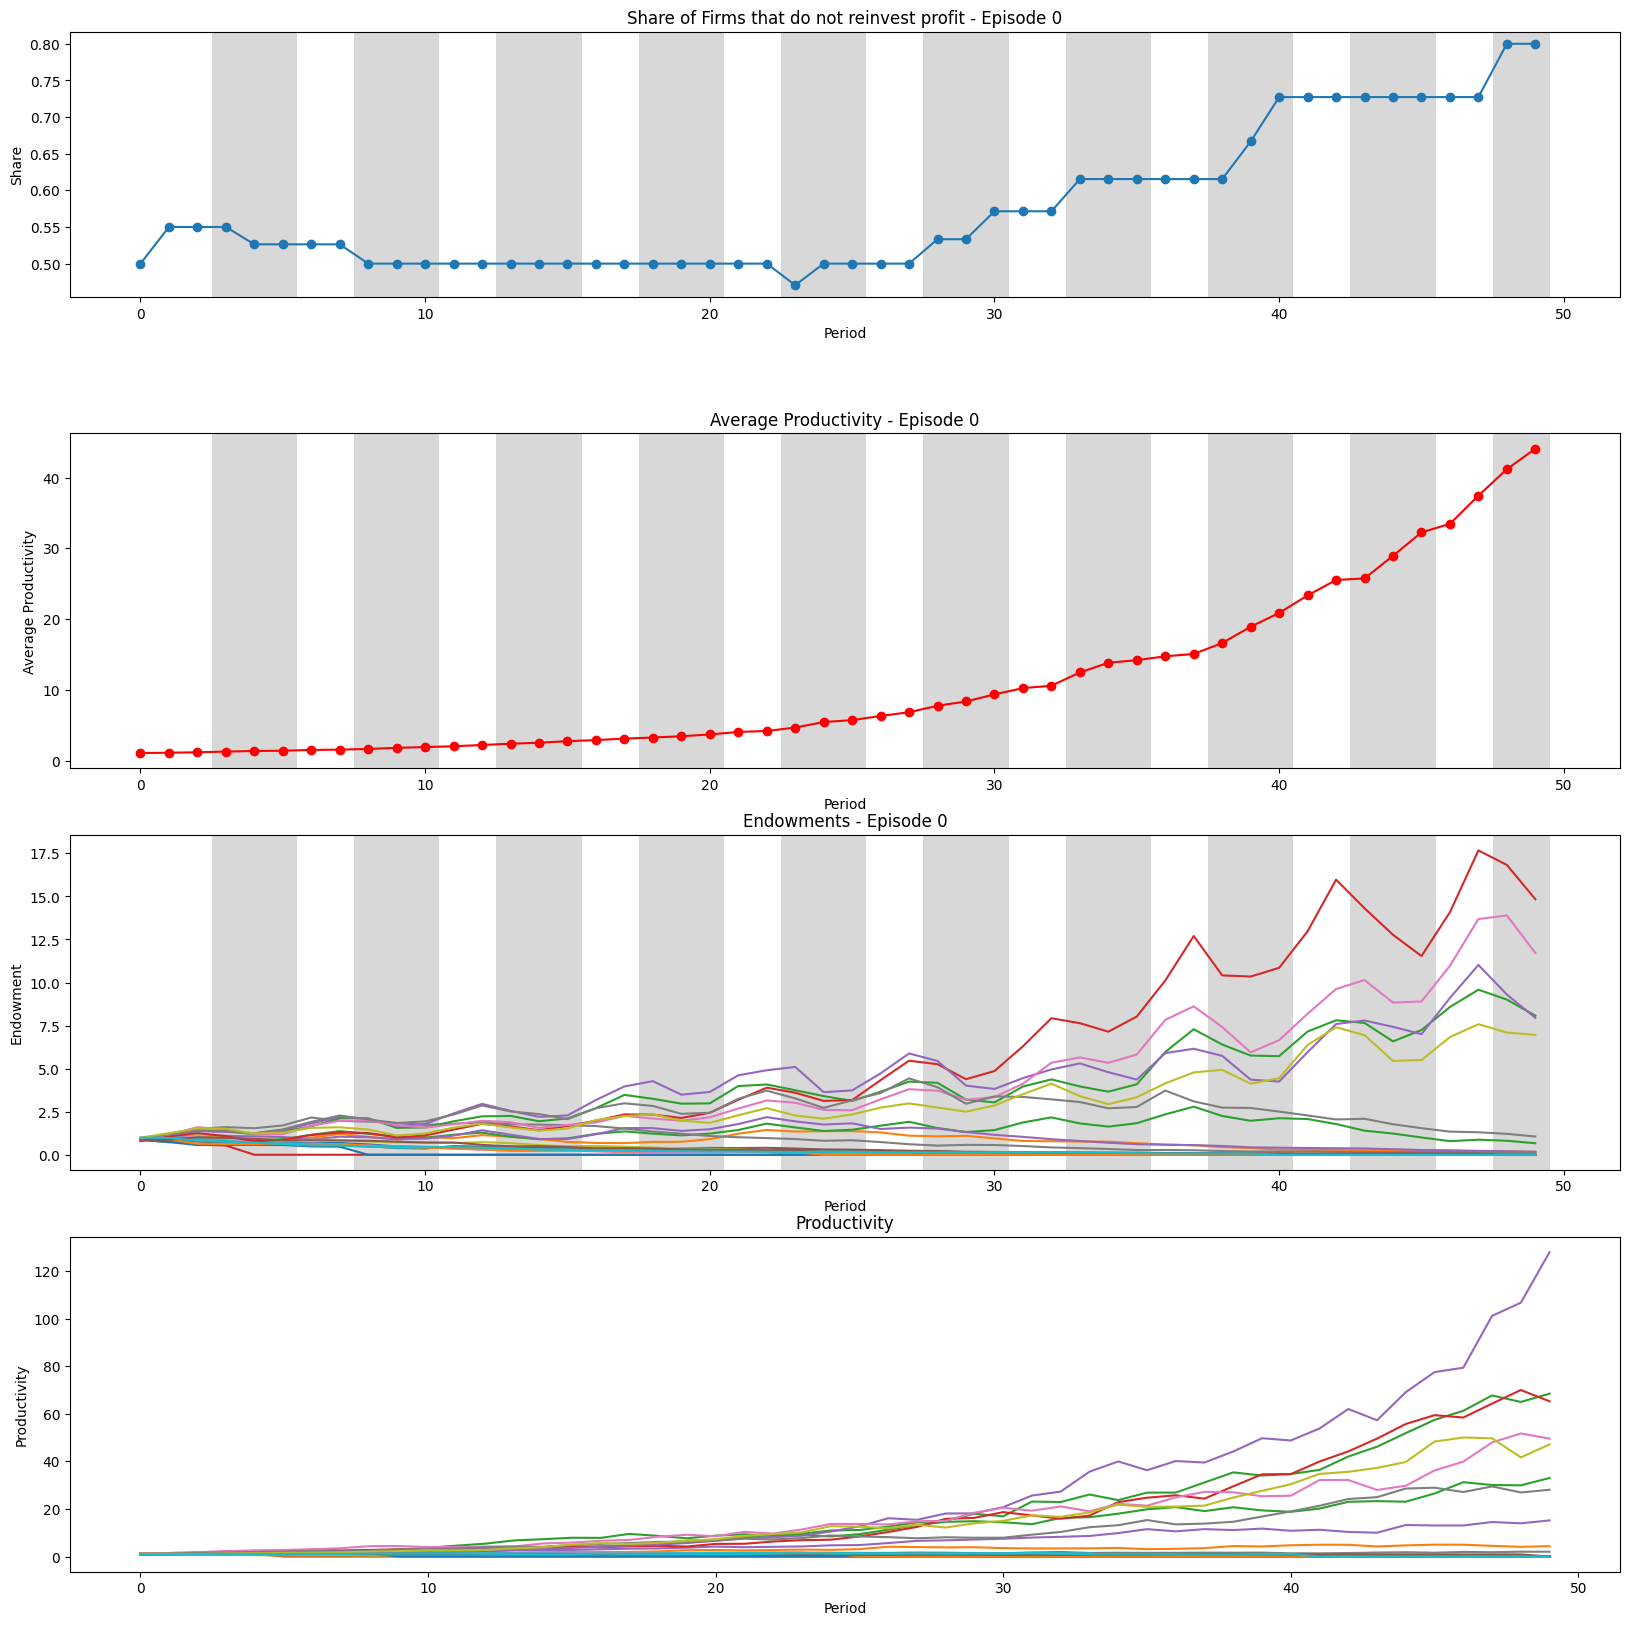

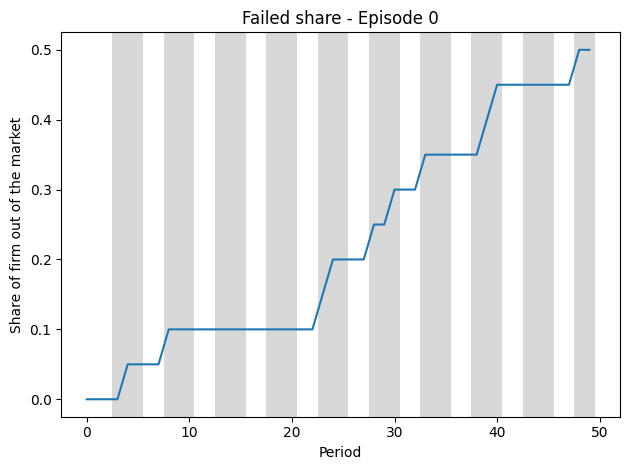

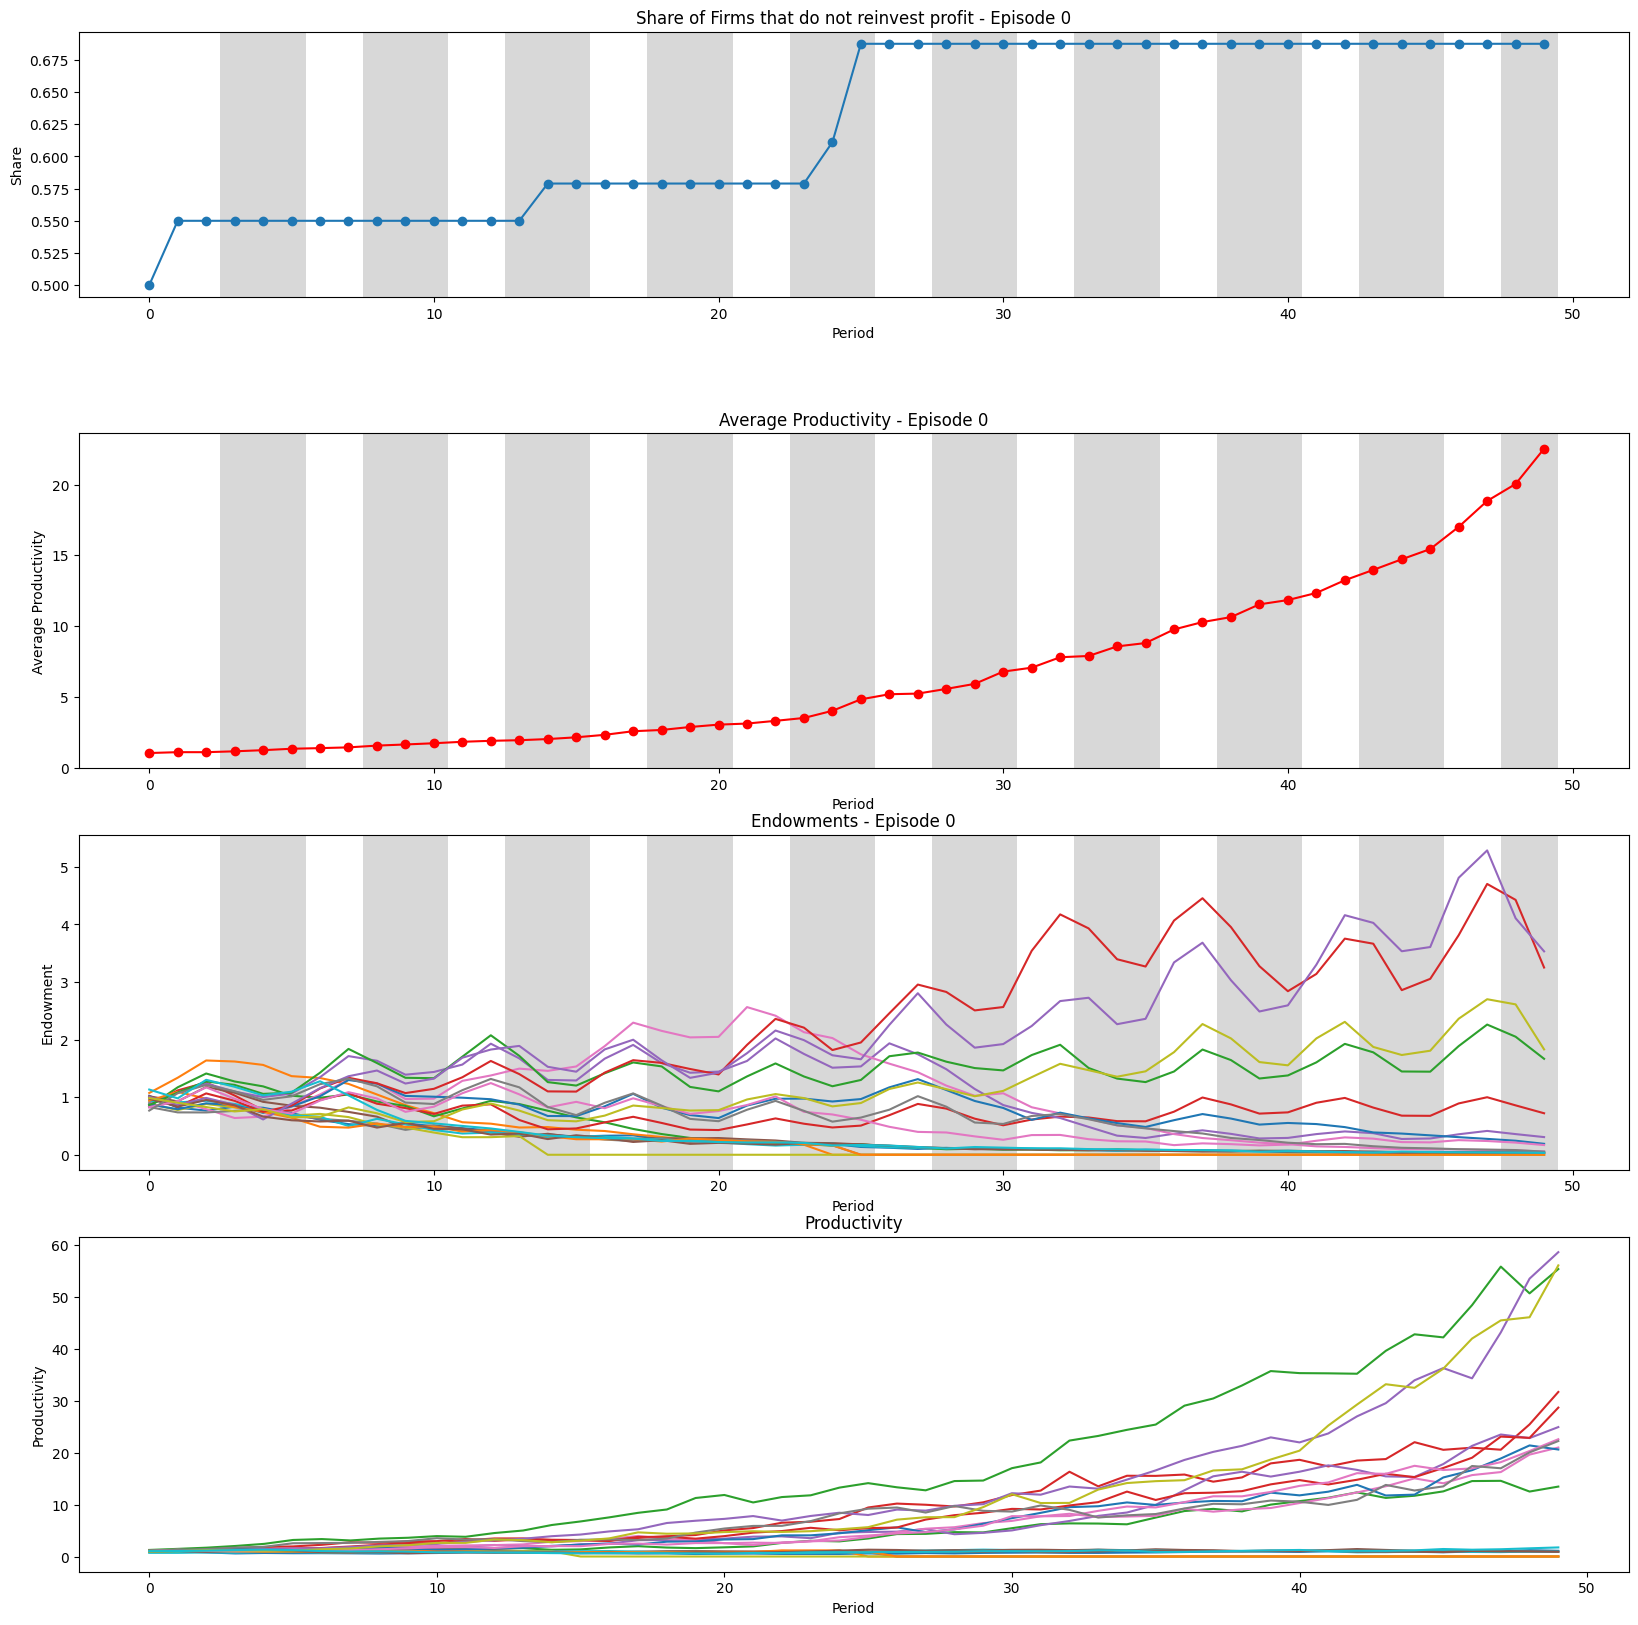

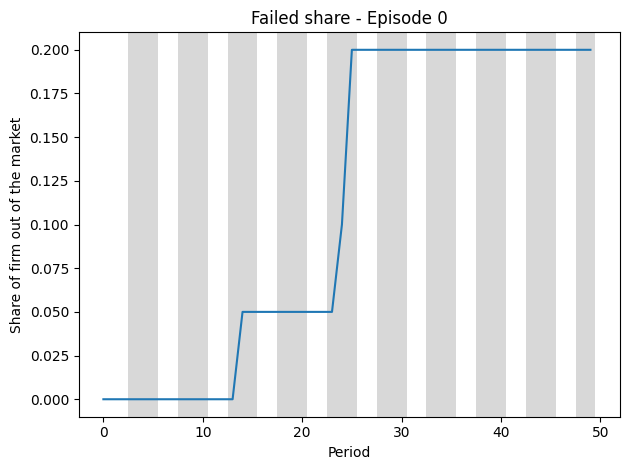

In [331]:
# Define the simulation function
def simulate_and_plot(num_episodes, firm_models, env):
    episode_results             = []
    
    for episode in range(num_episodes):

        # Reinforcement Learning Setup
        share_out_of_market_series  = []
        avg_productivity_series     = []
        productivity_series         = []
        endowments_series           = []
        cycle                       = []
        failed_series               = []
        #define history array
        history = np.zeros((env.num_firms, env.num_periods, 5))
        
        for period in range(env.num_periods):
            actions = []
            current_state = np.array([env.endowments.copy(), env.productivity.copy()])

            # Generate a sine wave for recession with a period of 5
            sine_wave_value = np.sin(2 * np.pi * period / 5)

            # Convert the sine wave value to recession
            env.recession = sine_wave_value

            for i in range(env.num_firms):
                action = get_action(history[i, 0 if period < 4 else period - 4 : 4 if period < 4 else period, :], 0, firm_models[i])
                action = [item for sublist in action for item in sublist]
                actions.append(action)
             # Slice the actions list to select only the actions for the current period
            if period<4:
                actions_for_period = [action[period] for action in actions]
            else:
                actions_for_period = [action[3] for action in actions]
            rewards, next_end, next_prod, failed, avg_productivity  = env.step(actions_for_period)

            share_out_of_market_series.append(((np.count_nonzero(actions_for_period * (1-failed))) / (env.num_firms - np.count_nonzero(failed))))
            avg_productivity_series.append(avg_productivity)
            productivity_series.append(next_prod)
            endowments_series.append(next_end)
            cycle.append(False if env.recession>=0 else True)
            failed_series.append(np.count_nonzero(failed)/env.num_firms)
        
        # Append the episode results
        episode_results.append({
            "avg_productivity_series": avg_productivity_series,
            "endowments_series": endowments_series,
            "share_out_of_market_series": share_out_of_market_series,
            "productivity_series": productivity_series,
            "cycle":   cycle,
            "Failed": failed_series
        })

        for firm_index in range(env.num_firms):
                history[firm_index, period, 0] = rewards[firm_index]
                history[firm_index, period, 1] = current_state[0, firm_index]
                history[firm_index, period, 2] = current_state[1, firm_index]
                history[firm_index, period, 3] = int(actions_for_period[firm_index])
                history[firm_index, period, 4] = env.avg_productivity
                
                current_state[0, firm_index] = next_end[firm_index]
                current_state[1, firm_index] = next_prod[firm_index]

    # Plot the time series data for each episode
    for episode, results in enumerate(episode_results):
        avg_productivity_series = results["avg_productivity_series"]
        endowments_series = results["endowments_series"]
        share_out_of_market_series = results["share_out_of_market_series"]
        productivity_series = results['productivity_series']
        cycle               = results['cycle']
        failed_series       = results['Failed']
        
        plt.figure(figsize=(20, 20))
        plt.subplot(5, 1, 1)
        plt.plot(share_out_of_market_series, marker='o')
        # Plot the recession cycles as grey shaded areas
        for i, is_recession in enumerate(cycle):
            if is_recession:
                plt.axvspan(i - 0.5, i + 0.5, facecolor='grey', alpha=0.3)
        plt.title(f"Share of Firms that do not reinvest profit - Episode {episode}")
        plt.xlabel("Period")
        plt.ylabel("Share")

        plt.subplot(4, 1, 2)
        plt.plot(avg_productivity_series, marker='o', color='r')
        for i, is_recession in enumerate(cycle):
            if is_recession:
                plt.axvspan(i - 0.5, i + 0.5, facecolor='grey', alpha=0.3)
        plt.title(f"Average Productivity - Episode {episode}")
        plt.xlabel("Period")
        plt.ylabel("Average Productivity")

        plt.subplot(4, 1, 3)
        plt.plot(endowments_series)
        for i, is_recession in enumerate(cycle):
            if is_recession:
                plt.axvspan(i - 0.5, i + 0.5, facecolor='grey', alpha=0.3)
        plt.title(f"Endowments - Episode {episode}")
        plt.xlabel("Period")
        plt.ylabel("Endowment")

        plt.subplot(4, 1, 4)
        plt.plot(productivity_series)
        plt.title("Productivity")
        plt.xlabel("Period")
        plt.ylabel("Productivity")
        plt.show()

        plt.plot(failed_series)
        for i, is_recession in enumerate(cycle):
            if is_recession:
                plt.axvspan(i - 0.5, i + 0.5, facecolor='grey', alpha=0.3)
        plt.title(f"Failed share - Episode {episode}")
        plt.xlabel("Period")
        plt.ylabel("Share of firm out of the market")

        plt.tight_layout()
        plt.show()
random.seed(1234)
env         = FirmEnvironment(20, 50, False) 
# Call the simulate_and_plot function with the desired number of episodes and the firm_models array
simulate_and_plot(num_episodes = 1, firm_models = loaded_firm_models, env = env)
env         = FirmEnvironment(20, 50, True) 
# Call the simulate_and_plot function with the desired number of episodes and the firm_models array
simulate_and_plot(num_episodes = 1, firm_models = loaded_firm_models, env = env)
